In [1]:
## Setup
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = [14, 4]
import pmdarima as pm
from pmdarima.arima import auto_arima

## Exploratory Data Analysis

The dataset weather-data.csv is obtained from [IOWA Environmental Mesonet - Iowa State University](https://mesonet.agron.iastate.edu/)

Columns for this dataset:

+ station: Acronym for the place of data capture.
+ valid: Date and time of capture.
+ tmpc: Temperature of the environment in celsius.
+ dwpc: Temperature of the dew point in the environment in celsius.
+ relh: Relative humidity of the environment in percentage.
+ sknt: Wind Speed in knots.
+ gust: Wind Gust in knots.
+ peak_wind_drct: Peak Wind Gust Direction (from PK WND METAR remark). (deg).

In [2]:
data = pd.read_csv('weather-data.csv')
data.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


At a first glance, it's easy to spot that the data is sampled at a 30-min interval, so a time series modeling can be used at a later stage.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


In [4]:
data['valid'] = data['valid'].astype("datetime64")
data.set_index('valid', inplace=True)

'valid' should be of datatime type and the index for the dataframe.

In [5]:
len(data[' station'].unique())

1

In [6]:
data.drop('peak_wind_drct', 1, inplace=True)
data.drop(' station', 1, inplace=True)

 peak_wind_drct' can be dropped as it has no non-null value, and 'station' can be dropped as it has a single value of 'NZAA'. Imputation should be considered at a later stage for other columns where there are some missing values (the number of non-null values is less than the record number), such as 'dwpc' (103678 < 103713). 

<AxesSubplot:>

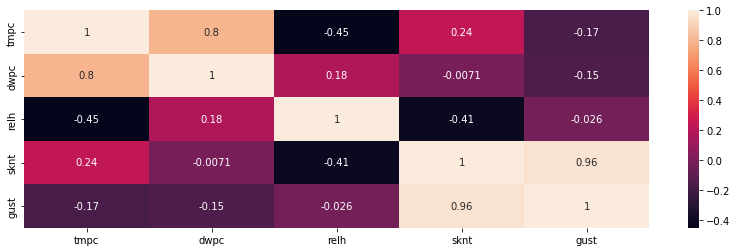

In [7]:
sns.heatmap(data.corr(), annot=True)

The dew point temperature is the temperature to which air must be cooled to become saturated with water vapor, assuming constant air pressure and water content. Therefore, it is understandably correlated with the temperature (the air needed to be cooled), relative humidity (water content) and the wind speed/gust (air pressure). Apart from that, the correlation between the wind speed and the wind gust is quite noticable.

In [8]:
data.describe()

,tmpc,dwpc,relh,sknt,gust
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000
mean,15.811503,12.115772,79.782307,8.919029,30.962594
std,4.235197,3.738005,12.562199,5.348379,6.319510
min,2.000000,-2.000000,29.230000,0.000000,13.000000
25%,13.000000,9.000000,71.450000,5.000000,27.000000
50%,16.000000,12.000000,81.990000,8.000000,31.000000
75%,19.000000,15.000000,88.180000,12.000000,35.000000
max,29.000000,23.000000,100.000000,42.000000,56.000000


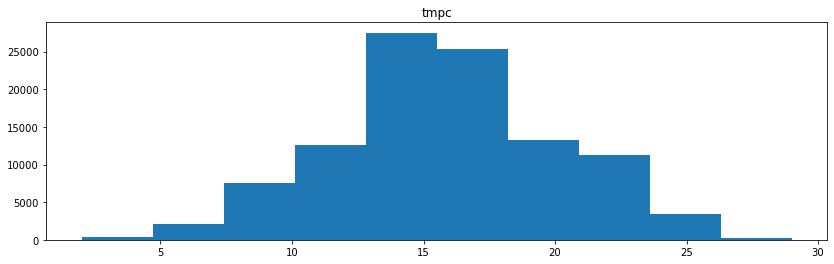

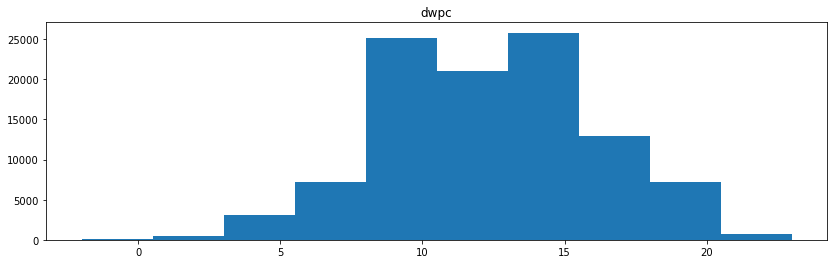

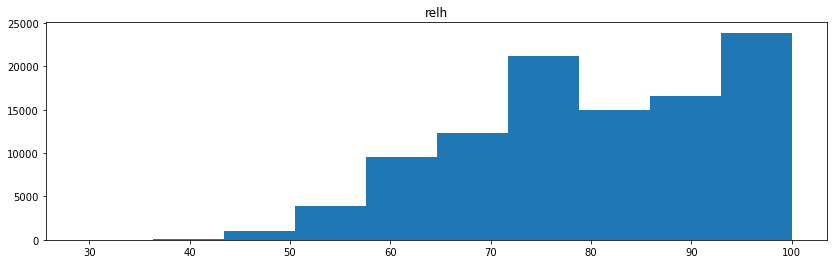

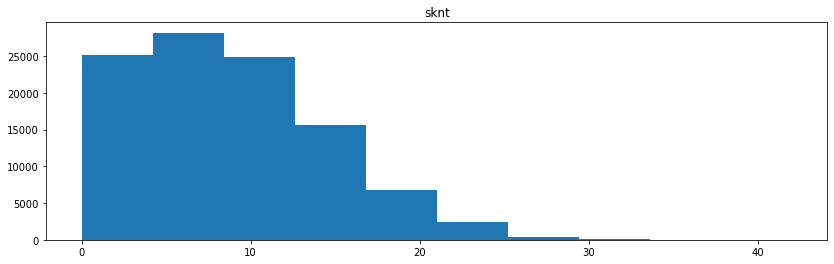

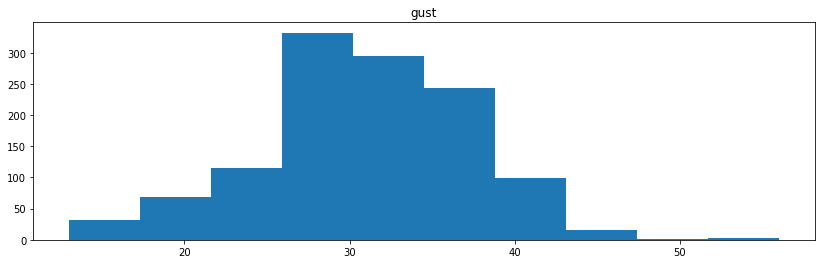

In [9]:
# distributions
for column_name in data.columns:
    plt.hist(data[column_name])
    plt.title(column_name)
    plt.show()

Since they're all numeric values, we care about distributions. Temperature and dew point temperature are approximately normally distributed, while others are skewed.

## Data Preparation

### Imputation
We impute missing values in the whole data set - it will yield similar results if we do it separately for the train and test sets as it's only to utilize the closest valid observations rather than other approaches such as extracting different means from the train and test sets for normalization.

In [10]:
data['gust'].fillna(data['sknt'], inplace=True)

When 'gust' is nan, there's assumingly no significant change in the wind speed. -> it can be filled with the wind speed at the same time.

In [11]:
data.fillna((data.fillna(method='bfill')+data.fillna(method='ffill'))/2, inplace=True)

When other columns are nan, we assume they don't significantly change over a short period. -> they can be filled with the average of the last and the next valid observations.

### Preprocessing

#### Train and test sets

In [12]:
pd.date_range(data.index.min(), data.index.max())

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=2191, freq='D')

The data spanned 6 years from 2015 to 2020. 

In [13]:
train = data[:'2020-09'].resample("W").mean()
test = data['2020-10':].resample("W").mean()

We use the last 3 months to evaluate our model. As we upsample it to weekly means, we assume the seasonality is of yearly 52-week windows.

## Data Modelling

#### Visualize the Time Series

In [14]:
## helper function to create run-sequence, rolling mean and rolling standard deviation
def rollingplot(column_name):
    #Determing rolling statistics
    rolmean = train[column_name].rolling(window=52).mean()
    rolstd = train[column_name].rolling(window=52).std()

    #Plot rolling statistics:
    orig = plt.plot(train[column_name], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(column_name)
    plt.grid()
    plt.show(block=False)

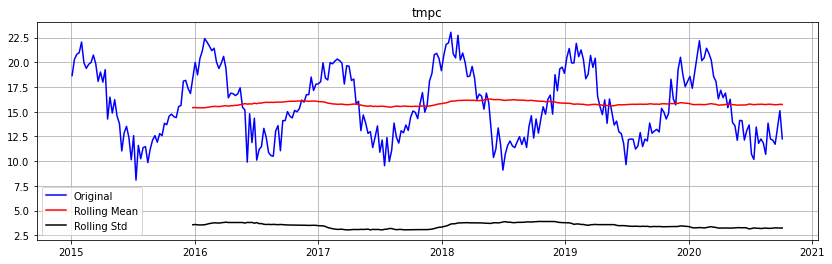

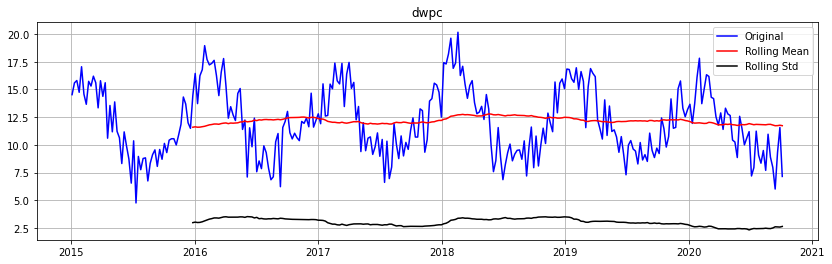

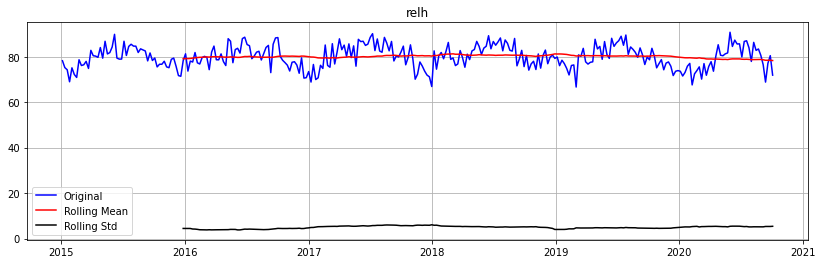

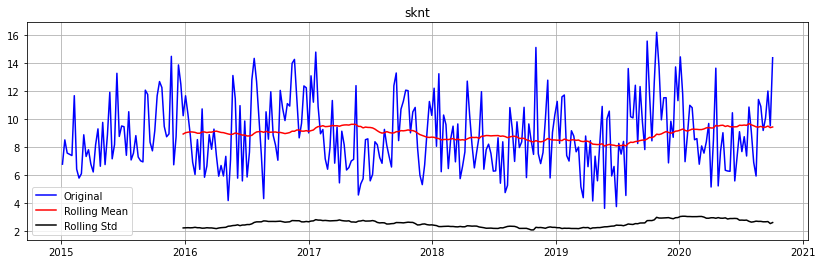

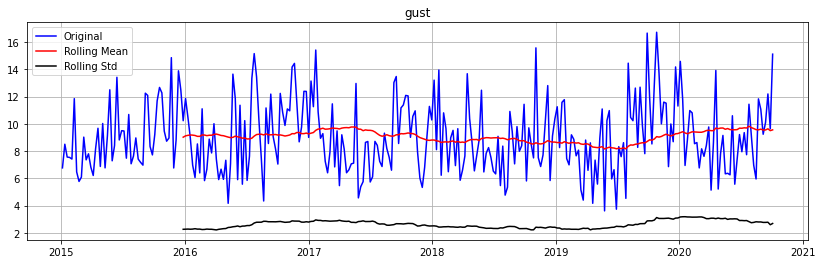

In [15]:
## plot against each column
for column_name in train.columns:
    rollingplot(column_name)

We can see from the plots that they are all additive models with strong seasonality for the first three columns and no obvious trend for all the columns.

#### Dickey-Fuller Test

In [16]:
## helper function to perform a Dickey-Fuller Test where the null hypothesis is that the series is not stationary
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [17]:
## test against each column
for colunm_name in train.columns:
    print("Please find the result below for %s: "%(colunm_name))
    dftest(train[[colunm_name]])
    print("\n")

Please find the result below for tmpc: 
Test Statistic         -7.533179e+00
p-value                 3.534207e-11
Lags Used               1.500000e+01
Observations Used       2.850000e+02
Critical Value (1%)    -3.453505e+00
Critical Value (5%)    -2.871735e+00
Critical Value (10%)   -2.572202e+00
dtype: float64


Please find the result below for dwpc: 
Test Statistic         -6.183423e+00
p-value                 6.373571e-08
Lags Used               1.300000e+01
Observations Used       2.870000e+02
Critical Value (1%)    -3.453342e+00
Critical Value (5%)    -2.871664e+00
Critical Value (10%)   -2.572164e+00
dtype: float64


Please find the result below for relh: 
Test Statistic           -3.841106
p-value                   0.002514
Lags Used                 3.000000
Observations Used       297.000000
Critical Value (1%)      -3.452561
Critical Value (5%)      -2.871321
Critical Value (10%)     -2.571982
dtype: float64


Please find the result below for sknt: 
Test Statistic           -

They all pass the test with the p-value small enough (< 0.05) to reject the null hypothesis, i.e., they are all stationary. However, bear in mind that both rolling mean/std plots and df tests can't capture seasonality, and we need to address that using SARIMA model.

#### Find Optimal Parameters

In [18]:
# helper function to plot acf and pacf
def acfplot(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=False)
    sns.despine()
    plt.tight_layout()

Moving forward, we will focus on tmpc as there could be some seasonality issues, and others could use a similar or simplified approach.

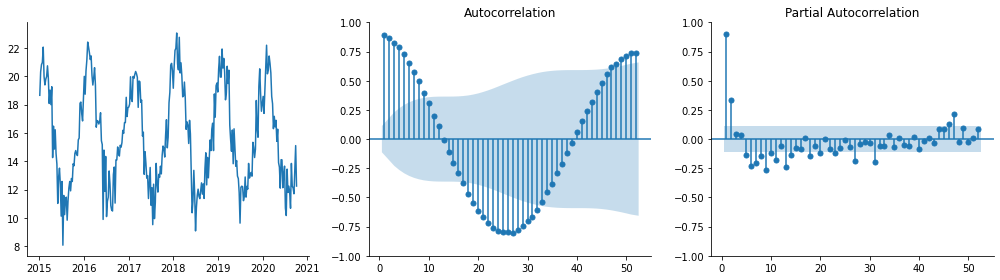

In [19]:
tmpc_train = train[['tmpc']]
tmpc_test = test[['tmpc']]
acfplot(tmpc_train, 52)

We can see from pacf that the order of p caps at 2 and acf that the autocorrelation doesn't decay away, and recurs over time, indicating an MA model should not be used.

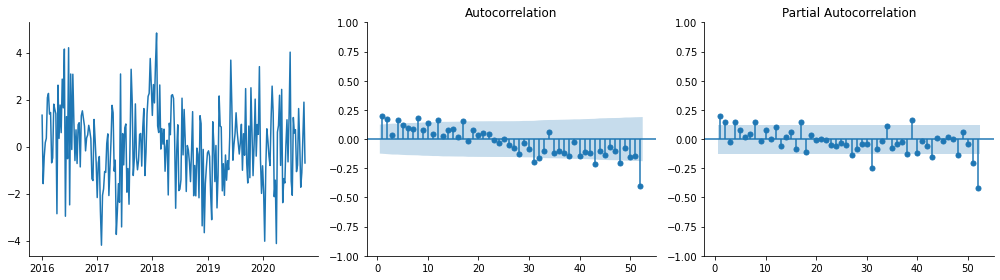

In [20]:
acfplot(tmpc_train.diff(52).dropna(), 52)

We can see from pacf that the order of seasonal P caps 2 and acf that the order of seasonal Q caps at 2.

In [21]:
stepwise_model = pm.auto_arima(tmpc_train, start_p=0, start_q=0,
                           max_p=2, max_q=0, m=52,
                           start_P=0, start_Q=0, seasonal=True,
                           max_P=2, max_Q=2,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1607.948, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1114.813, Time=3.76 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2530.036, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1116.219, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=1116.724, Time=42.67 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=28.65 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1076.349, Time=4.14 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1082.717, Time=0.03 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=1075.985, Time=37.57 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=39.82 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=in

We narrow down the search to find the best model ARIMA(2,0,0)(2,0,0)[52] with the lowest AIC.

In [22]:
sar = sm.tsa.statespace.SARIMAX(tmpc_train, 
                                order=(2,0,0), 
                                seasonal_order=(2,0,0,52), 
                                trend='c').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41614D+01    |proj g|=  4.17484D+01


 This problem is unconstrained.



At iterate    5    f=  2.25412D+00    |proj g|=  2.28661D-01

At iterate   10    f=  2.16539D+00    |proj g|=  8.20872D-02

At iterate   15    f=  2.14779D+00    |proj g|=  1.74718D-01

At iterate   20    f=  1.98182D+00    |proj g|=  6.74428D-01

At iterate   25    f=  1.91213D+00    |proj g|=  1.86063D-01

At iterate   30    f=  1.84291D+00    |proj g|=  1.92881D-01

At iterate   35    f=  1.76986D+00    |proj g|=  6.91306D-02

At iterate   40    f=  1.76742D+00    |proj g|=  4.69389D-04

At iterate   45    f=  1.76742D+00    |proj g|=  1.18809D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     60   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               tmpc   No. Observations:                  301
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -531.993
Date:                            Tue, 18 Oct 2022   AIC                           1075.985
Time:                                    14:36:09   BIC                           1098.228
Sample:                                01-04-2015   HQIC                          1084.886
                                     - 10-04-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1381      0.373      3.054      0.002       0.408       1.869
ar.L1          0.5233      0.057      9.102      0.000       0.411       0.636
ar.L2          0.3733      0.056      6.666      0.000       0.264       0.483
ar.S.L52       0.1834      0.070      2.629      0.009       0.047       0.320
ar.S.L104      0.1181      0.064      1.857      0.063      -0.007       0.243
sigma2         1.9728      0.153     12.861      0.000       1.672       2.273
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                11.29
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.42
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we've got a fitted model for prediction!

#### Prediction

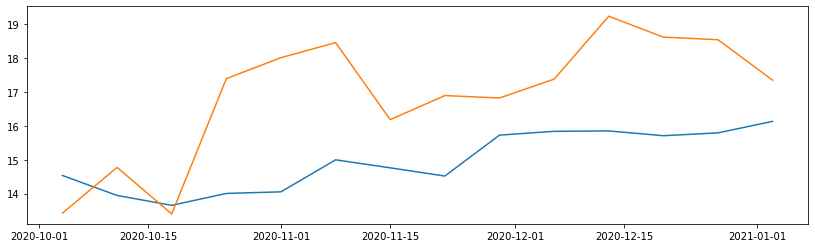

In [24]:
forecast = sar.predict(start = len(tmpc_train)-1, end= len(tmpc_train)+len(tmpc_test)-2)
plt.plot(forecast)
plt.plot(tmpc_test)

Cross-validation isn't working for time series for we have to test against the forecast horizon instead of randomized observations. Therefore, we plot the hold-out test set and prediction together to see if it's a good fit.